<a href="https://colab.research.google.com/github/ggravity06/ggravity06/blob/main/%E0%B8%B4botNoi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install flaml -q

In [12]:
import numpy as np

# เพิ่ม attribute np.NaN กลับเข้าไป ให้ lib เก่าใช้ได้
if not hasattr(np, "NaN"):
    np.NaN = np.nan


In [13]:
import pandas as pd
from flaml import AutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import pickle

# แก้ชื่อไฟล์ตามที่คุณอัปโหลดไว้ใน Colab
raw_path = "Coffe_sales(1).csv"
raw = pd.read_csv(raw_path)

print("Raw head:")
print(raw.head())


Raw head:
   hour_of_day cash_type  money    coffee_name Time_of_Day Weekday Month_name  \
0           10      card   38.7          Latte     Morning     Fri        Mar   
1           12      card   38.7  Hot Chocolate   Afternoon     Fri        Mar   
2           12      card   38.7  Hot Chocolate   Afternoon     Fri        Mar   
3           13      card   28.9      Americano   Afternoon     Fri        Mar   
4           13      card   38.7          Latte   Afternoon     Fri        Mar   

   Weekdaysort  Monthsort        Date             Time  
0            5          3  2024-03-01  10:15:50.520000  
1            5          3  2024-03-01  12:19:22.539000  
2            5          3  2024-03-01  12:20:18.089000  
3            5          3  2024-03-01  13:46:33.006000  
4            5          3  2024-03-01  13:48:14.626000  


In [14]:
def clean_raw_data(df: pd.DataFrame) -> pd.DataFrame:
    # ทำชื่อคอลัมน์ให้เรียบ ๆ หน่อย
    df = df.copy()
    df.columns = df.columns.str.strip()

    # คาดว่าไฟล์คุณมีคอลัมน์เหล่านี้อยู่แล้ว:
    # hour_of_day, cash_type, money, coffee_name,
    # Time_of_Day, Weekday, Month_name, Weekdaysort,
    # Monthsort, Date, Time

    # แปลง Date ให้เป็น datetime
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"])

    # แปลงเงินเป็น float
    df["money"] = (
        df["money"]
        .astype(str)
        .str.replace(",", "", regex=False)
        .str.strip()
        .astype(float)
    )

    # ทำชื่อเมนูให้สะอาดหน่อย
    df["coffee_name"] = df["coffee_name"].astype(str).str.strip()

    # Ensure Weekdaysort / Monthsort มีอยู่
    if "Weekdaysort" not in df.columns:
        df["Weekdaysort"] = df["Date"].dt.weekday + 1  # 1–7
    if "Monthsort" not in df.columns:
        df["Monthsort"] = df["Date"].dt.month

    return df

raw_clean = clean_raw_data(raw)
print("\nCleaned raw head:")
print(raw_clean.head())



Cleaned raw head:
   hour_of_day cash_type  money    coffee_name Time_of_Day Weekday Month_name  \
0           10      card   38.7          Latte     Morning     Fri        Mar   
1           12      card   38.7  Hot Chocolate   Afternoon     Fri        Mar   
2           12      card   38.7  Hot Chocolate   Afternoon     Fri        Mar   
3           13      card   28.9      Americano   Afternoon     Fri        Mar   
4           13      card   38.7          Latte   Afternoon     Fri        Mar   

   Weekdaysort  Monthsort       Date             Time  
0            5          3 2024-03-01  10:15:50.520000  
1            5          3 2024-03-01  12:19:22.539000  
2            5          3 2024-03-01  12:20:18.089000  
3            5          3 2024-03-01  13:46:33.006000  
4            5          3 2024-03-01  13:48:14.626000  


In [15]:
def build_daily_from_raw(raw_df: pd.DataFrame) -> pd.DataFrame:
    daily = (
        raw_df
        .groupby(["Date", "Weekdaysort", "Monthsort", "coffee_name"])
        .agg(
            Amount_of_Sale=("coffee_name", "count"),   # จำนวนแก้ว/เมนู/วัน
            Total_Revenue=("money", "sum")             # ยอดเงินรวม/เมนู/วัน
        )
        .reset_index()
    )

    daily = daily.rename(columns={
        "coffee_name": "Menu_Name",
        "Weekdaysort": "Weeksort",
        "Monthsort": "Monthsort"
    })
    return daily

daily = build_daily_from_raw(raw_clean)
print("\nDaily sales head:")
print(daily.head())



Daily sales head:
        Date  Weeksort  Monthsort            Menu_Name  Amount_of_Sale  \
0 2024-03-01         5          3            Americano               1   
1 2024-03-01         5          3  Americano with Milk               4   
2 2024-03-01         5          3                Cocoa               1   
3 2024-03-01         5          3        Hot Chocolate               3   
4 2024-03-01         5          3                Latte               2   

   Total_Revenue  
0           28.9  
1          135.2  
2           38.7  
3          116.1  
4           77.4  


In [16]:
def add_features(daily: pd.DataFrame) -> pd.DataFrame:
    df = daily.copy()
    df["Date"] = pd.to_datetime(df["Date"])

    # เรียงตามเมนู + วันที่ (สำคัญก่อน shift)
    df = df.sort_values(["Menu_Name", "Date"])

    # day_number: นับจากวันแรกใน dataset
    first_day = df["Date"].min()
    df["day_number"] = (df["Date"] - first_day).dt.days

    # sale_yesterday: ยอดขายเมนูนี้เมื่อวาน
    df["sale_yesterday"] = df.groupby("Menu_Name")["Amount_of_Sale"].shift(1)

    # sale_last_week: ยอดขายเมนูนี้เมื่ออาทิตย์ที่แล้ว (เลื่อน 7 วัน)
    df["sale_last_week"] = df.groupby("Menu_Name")["Amount_of_Sale"].shift(7)

    # เติม NaN จากวันแรก ๆ ด้วย 0
    df[["sale_yesterday", "sale_last_week"]] = df[["sale_yesterday", "sale_last_week"]].fillna(0)

    # is_weekend: 1 ถ้าเสาร์/อาทิตย์
    df["is_weekend"] = df["Weeksort"].isin([6, 7]).astype(int)

    return df

daily_feat = add_features(daily)
print("\nDaily with features head:")
print(daily_feat.head())



Daily with features head:
         Date  Weeksort  Monthsort  Menu_Name  Amount_of_Sale  Total_Revenue  \
0  2024-03-01         5          3  Americano               1           28.9   
5  2024-03-02         6          3  Americano               3           86.7   
7  2024-03-03         7          3  Americano               1           28.9   
20 2024-03-06         3          3  Americano               1           28.9   
23 2024-03-07         4          3  Americano               1           28.9   

    day_number  sale_yesterday  sale_last_week  is_weekend  
0            0             0.0             0.0           0  
5            1             1.0             0.0           1  
7            2             3.0             0.0           1  
20           5             1.0             0.0           0  
23           6             1.0             0.0           0  


In [17]:
# เลือกคอลัมน์ที่ใช้เป็น features (ไม่ต้องใช้ Date ตรง ๆ)
feature_cols = [
    "Weeksort",
    "Monthsort",
    "Menu_Name",
    "Total_Revenue",
    "day_number",
    "sale_yesterday",
    "sale_last_week",
    "is_weekend",
]

target_col = "Amount_of_Sale"

X = daily_feat[feature_cols]
y = daily_feat[target_col]

# แยก train / test สำหรับดู performance คร่าว ๆ
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

automl = AutoML()

settings = {
    "time_budget": 300,         # จำนวนวินาทีให้ค้นโมเดล (เช่น 300 = 5 นาที)
    "task": "regression",
    "metric": "r2",             # จะใช้ MAE/MSE ก็ได้
    "log_file_name": "coffee_flaml.log",
    "verbose": 1,
}

automl.fit(X_train=X_train, y_train=y_train, **settings)

print("\nBest model:", automl.model.estimator)
print("Best config:", automl.best_config)


INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune



Best model: LGBMRegressor(colsample_bytree=np.float64(0.9936948689866156),
              learning_rate=np.float64(0.5934036477514357), max_bin=63,
              min_child_samples=2, n_estimators=802, n_jobs=-1, num_leaves=4,
              reg_alpha=0.0009765625, reg_lambda=0.0009765625, verbose=-1)
Best config: {'n_estimators': 802, 'num_leaves': 4, 'min_child_samples': 2, 'learning_rate': np.float64(0.5934036477514357), 'log_max_bin': 6, 'colsample_bytree': np.float64(0.9936948689866156), 'reg_alpha': 0.0009765625, 'reg_lambda': 0.0009765625}


In [18]:
y_pred = automl.predict(X_test)

print("\nR2 score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))



R2 score: 0.9939577310424086
MAE: 0.030706992416942684


In [21]:
with open("/content/saleluzaa/coffee_sales_flaml.pkl", "wb") as f:
    pickle.dump(automl, f)

print("Model saved in saleluzaa folder")


Model saved in saleluzaa folder


# **Graph**

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# 1.1 Actual vs Predicted (test set)

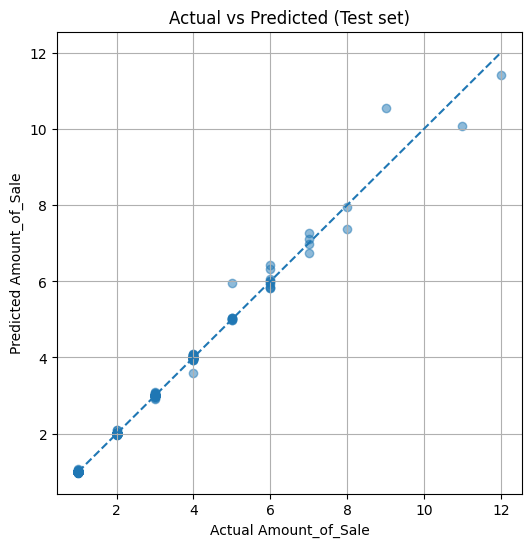

In [23]:
y_test_pred = automl.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Actual Amount_of_Sale")
plt.ylabel("Predicted Amount_of_Sale")
plt.title("Actual vs Predicted (Test set)")
plt.grid(True)
plt.show()


# 1.2 Residual plot (error vs prediction)

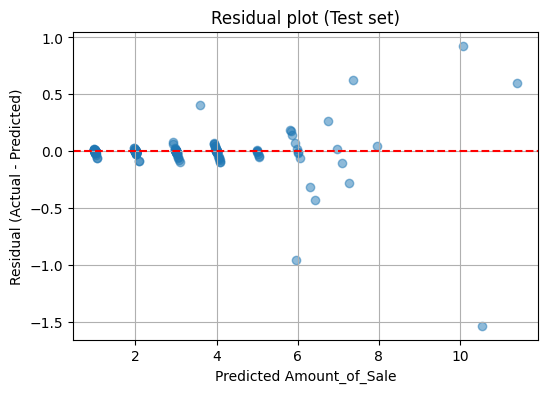

In [24]:
residuals = y_test - y_test_pred

plt.figure(figsize=(6,4))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Amount_of_Sale")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual plot (Test set)")
plt.grid(True)
plt.show()


# 1.3 Histogram ของ error

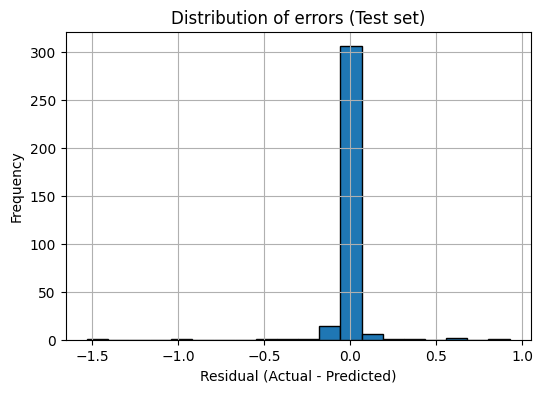

In [25]:
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=20, edgecolor="black")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of errors (Test set)")
plt.grid(True)
plt.show()


# 2️⃣ check overfit: train vs test

In [26]:
# บน train set
y_train_pred = automl.predict(X_train)

r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

# บน test set (ที่คุณมีอยู่แล้ว)
y_test_pred = automl.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("Train R2:", r2_train)
print("Train MAE:", mae_train)
print("Test  R2:", r2_test)
print("Test  MAE:", mae_test)


Train R2: 0.9999890813677876
Train MAE: 0.003069589350639585
Test  R2: 0.9939577310424086
Test  MAE: 0.030706992416942684


app.py
# **New Section**

In [27]:
pip install fastapi uvicorn flaml pandas python-multipart


In [31]:
!ls saleluzaa


app.py	coffee_sales_flaml.pkl	pipeline_utils.py  __pycache__


In [35]:
!uvicorn saleluzaa.app:app --host 0.0.0.0 --port 8000 --reload

INFO:     Will watch for changes in these directories: ['/content']
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [16070] using StatReload
INFO:     Started server process [16072]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [16072]
INFO:     Stopping reloader process [16070]


ใช้อันนี้ รันเป็น background แทน

In [37]:
!nohup uvicorn saleluzaa.app:app --host 0.0.0.0 --port 8000 --reload > server.log 2>&1 &


In [38]:
import requests

res = requests.get("http://0.0.0.0:8000/")
print(res.json())

{'message': 'Coffee Sales Prediction API is running!'}


In [39]:
!ps -ef | grep uvicorn

root       17096       1  2 02:27 ?        00:00:01 /usr/bin/python3 /usr/local/bin/uvicorn saleluzaa.app:app --host 0.0.0.0 --port 8000 --reload
root       17378     909  0 02:28 ?        00:00:00 /bin/bash -c ps -ef | grep uvicorn
root       17380   17378  0 02:28 ?        00:00:00 grep uvicorn


In [41]:
!tail -n 100 server.log



INFO:     Will watch for changes in these directories: ['/content']
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [17096] using StatReload
INFO:     Started server process [17102]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     127.0.0.1:59876 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:39428 - "GET / HTTP/1.1" 200 OK


In [42]:
import requests

files = {"file": open("Coffe_sales(1).csv", "rb")}
res = requests.post("http://0.0.0.0:8000/predict", files=files)

print(res.status_code)
print(res.json()[:5])  # ดูแค่ 5 แถวแรกพอ


200
[{'Date': '2024-03-01T00:00:00', 'Menu_Name': 'Americano', 'Amount_of_Sale': 1, 'Predicted_Amount_of_Sale': 1.0011643627433267}, {'Date': '2024-03-02T00:00:00', 'Menu_Name': 'Americano', 'Amount_of_Sale': 3, 'Predicted_Amount_of_Sale': 2.9965326277611797}, {'Date': '2024-03-03T00:00:00', 'Menu_Name': 'Americano', 'Amount_of_Sale': 1, 'Predicted_Amount_of_Sale': 1.0002533813623384}, {'Date': '2024-03-06T00:00:00', 'Menu_Name': 'Americano', 'Amount_of_Sale': 1, 'Predicted_Amount_of_Sale': 0.9997834859832382}, {'Date': '2024-03-07T00:00:00', 'Menu_Name': 'Americano', 'Amount_of_Sale': 1, 'Predicted_Amount_of_Sale': 0.9984846538629595}]
